## <h3 align="center">Statistical Analysis and Modeling of Neural Data (NEU 560)</h3>

<h4 align="center">Princeton University, Spring 2024</h4>
<h4 align="center">Jonathan Pillow</h4>

---

## Homework 4: Latent Variable Models: Mixtures of Gaussians, Factor Analysis, & PPCA

#### Due: Thursday 4/25 at 11:59pm

#### <b>Student's 3-digit Class Number</b>: 255

---


---

### Formatting & Submission Instructions

- Please prepare your homework submission completely within your own copy of this colab notebook.

- For each problem or sub-problem, please **limit yourself to one Code cell and/or one Markdown cell** as appropriate (switch between them by using the menu at the top, or the shortcuts `Esc + M` for Markdown and `Esc + Y` for Code). Of course, feel free to use as many cells as you like in the course of working on the homework, just clean and condense once you're done!

- **Comments**: Comments within code cells can be useful for explaining your code and thought process as necessary (anything following a `#` is a comment in Python; you can quickly (un)comment blocks of code by highlighting it and using the shortcut `Cmd + /`. See the posted solution for Homework 0 for examples of the desired formatting).

- **Grading**: All problems or sub-problems are worth 1pt each unless otherwise marked.

- **Submitting your homework**: Please submit by sending an _editable_ link to your notebook, via an email to Victor (vg0233@princeton.edu). We are going to use anonymous grading, so PLEASE PUT YOUR STUDENT # IN THE APPROPRIATE FIELD ABOVE BEFORE SUBMITTING.

- **Test before submmitting**: Before submitting, make sure to verify that your code runs without errors by selecting `Runtime -> Restart & Run All`.


---

Before we start let's import some of our favorite packages:


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [36]:
### Download spike-sorting data

!wget https://github.com/pillowlab/neu560data/blob/master/extracellrec.mat?raw=true
# Rename raw files with the mv utility
!mv extracellrec.mat\?raw\=true extracellrec.mat

zsh:1: no matches found: https://github.com/pillowlab/neu560data/blob/master/extracellrec.mat?raw=true
mv: extracellrec.mat?raw=true: No such file or directory


---

## 1) Spike sorting of extracellular neural recordings

The gold standard of electrophysiology is high signal-to-noise ratio of an active, well-isolated neuron, but extracellular recordings, by their nature, tend to detect activity of several neurons surrounding the probe. The post-processing problem of identifying which spike came from which neuron is called _spike sorting_, and it's fundamentally the same latent variable recognition problem we've developed in class.

Spike sorting is not a solved problem, but the current state-of-the-art spike sorting algorithms tend to follow the same procedure:


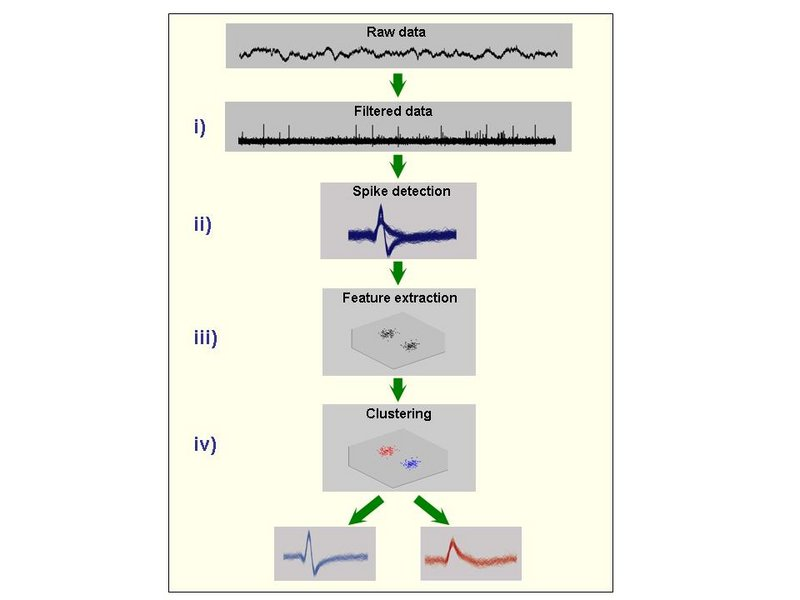


We've already performed steps **(i)** and **(ii)** for you. In general, we'll use a finite impulse-response bandpass filter. Spike detection (as employed here) tends to use a threshold-crossing procedure. Every time the voltage trace crosses a negative threshold, set here at -65 mV, we grab 48 samples and align the spikes to this threshold crossing.

Load the file `extracellrec.mat`, which contains multiunit extracellular recordings from a single electrode. A single variable `spkwf` loads, an 80397 x 48 matrix of 80397 spikes over 48 time points, aligned to their negative threshold crossing pre-spike.

For multielectrode data such as that from 10x10 Utah arrays, we can imagine repeating the procedure over and over. However, for electrodes very close to each other, such as in hippocampal tetrodes and multilead electrode shanks, the same neuron can appear on multiple electrodes, demanding a source localization technique but dramatically amplifying signal efficacy. For those interested, modern tech like the UCL NeuroPixel [http://www.ucl.ac.uk/neuropixels] or the NeuroSeeker silicon polytrode [http://www.kampff-lab.org/validating-electrodes/] are pushing the boundary in exciting ways.


In [37]:
data = loadmat('extracellrec.mat')
Stim = data['spkwf']
n_spk = Stim.shape[0]
T = Stim.shape[1]

**a)** Plot 100 random waveforms from this set. How many neurons does it seem like this electrode detected?


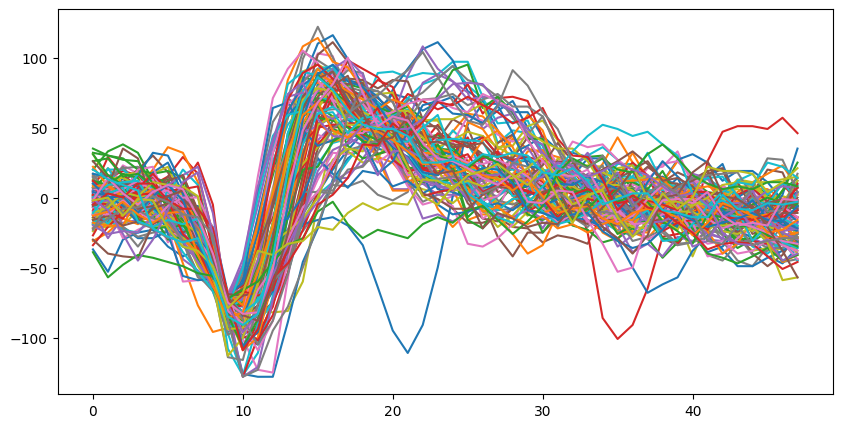

In [38]:
plt.figure(figsize=(10, 5))
random_waveforms = np.random.choice(n_spk, 100, replace=False)
for i in random_waveforms:
    plt.plot(Stim[i, :])
    
plt.show()

# maybe around 2-5 neurons?

**b) Feature extraction.** Each spike, then, is a 48-dimensional vector, which in most applications is more data than we need to solve the problem. Write a function `ppca` to project the data down to fewer dimensions using Probabilistic Principal Components Analysis.


In [39]:
def ppca(X, k):
    """
    Probabilistic PCA
    """
    mean = np.mean(X, axis=0)
    centered_data = X - mean
    
    cov_matrix = np.cov(centered_data, rowvar=False)
    
    U, S, Vh = np.linalg.svd(cov_matrix, full_matrices=False)
        
    principal_components = Vh[:k].T

    projected_data = centered_data @ principal_components
    
    noise_var = np.mean(S[k:])
        
    return projected_data, principal_components, noise_var

**c)** Project the data down to two dimensions. Since we have a lot of spikes, rather than scatter-plotting the resulting data, make a 2-dimensional histogram and plot it as a heatmap. Now how many neurons does it seem like this electrode detected?


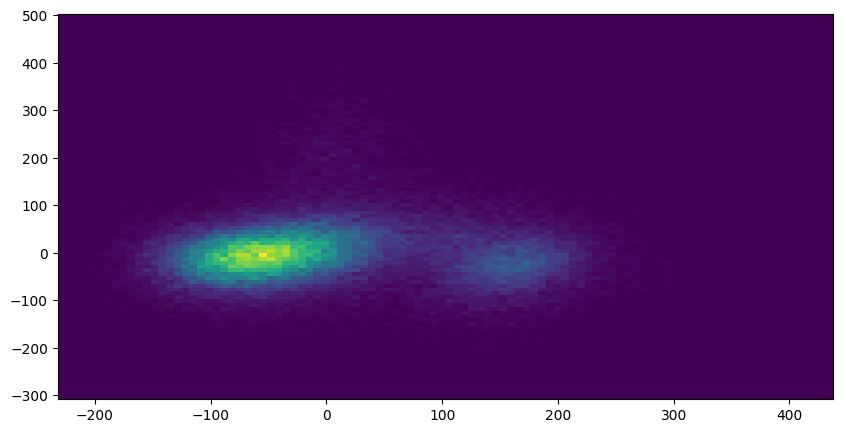

In [40]:
projected_2d_data, pcs, _ = ppca(Stim, 2)

plt.figure(figsize=(10, 5)) 
plt.hist2d(projected_2d_data[:, 0], projected_2d_data[:, 1], bins=100)

plt.show()

# 2 neurons

**d)** Plot these first two principal components. What information do they seem to capture about the temporal dynamics of the spikes?


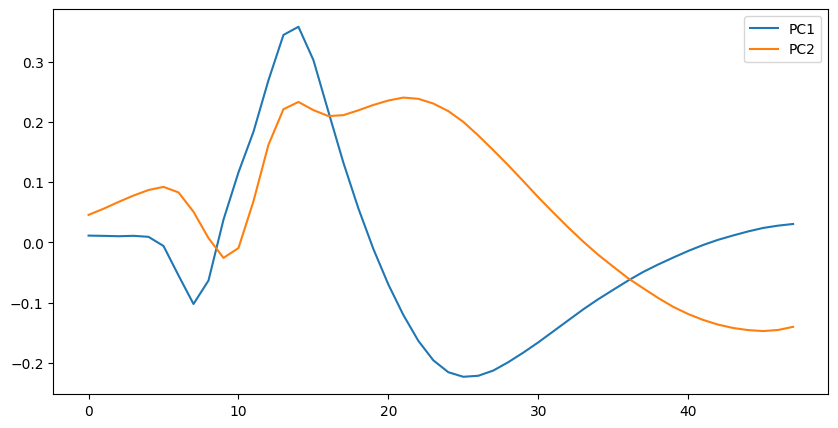

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(-pcs[:, 0], label='PC1')
plt.plot(-pcs[:, 1], label='PC2')
plt.legend()

# Blue PC seems to be looking at the spike depolarization and more so
# the hyperpolarization/refactory period of spikes

# Orange PC seems to be looking at longer/drawn out repolarization of spikes

**e) Clustering.** Implement your own version of k-means clustering, and use it to identify clusters in these data. (You may wish to compare the performance of your algorithm to `sklearn.cluster.KMeans` to make sure it is performing correctly).

Perform k-means clustering for several different `k` and scatter plot your best results, colorizing each spike with the cluster to which it was assigned.

_(Style recommendation: use colors c=[1,0,0], [0,1,0], or [0,0,1] (if you find three clusters, or any pair if you find two clusters) for reasons that will make more sense in the next section)_


In [42]:
def cluster(X, k):
    """
    k-means clustering
    """
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    wcss = 0
        
    while True:
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        
        if np.all(centroids == new_centroids):
            break
            
        centroids = new_centroids
        wcss = np.sum([distances[i, labels[i]]**2 for i in range(X.shape[0])])
    
    return labels, centroids, wcss

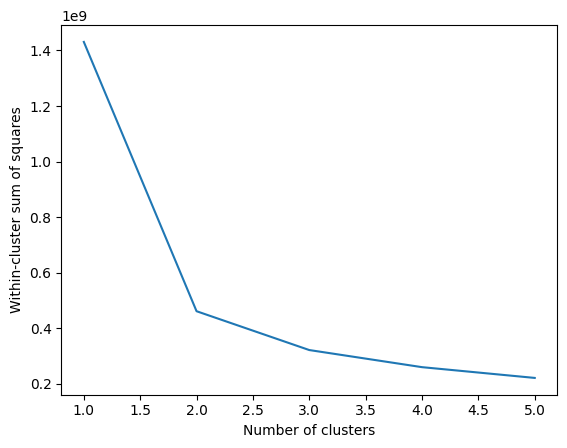

In [43]:
wcss = []
for i in range(1, 6):
    kmeans = cluster(projected_2d_data, i)
    wcss.append(kmeans[2])

plt.plot(range(1, 6), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares')
plt.show()

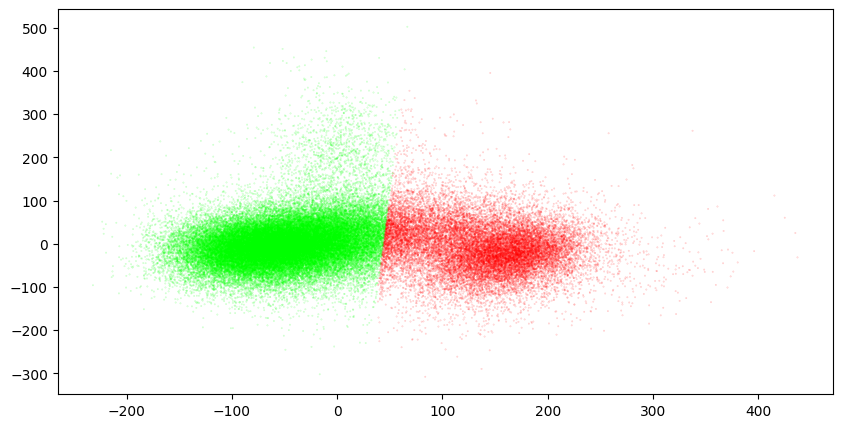

In [44]:
labels, centroids, wcss = cluster(projected_2d_data, 2)

colors = np.array([[1, 0, 0], [0, 1, 0]])

plt.figure(figsize=(10, 5))
plt.scatter(projected_2d_data[:, 0], projected_2d_data[:, 1], c=colors[labels], alpha=0.25, s=0.1)
plt.show()

**f)** Write a function to use the EM algorithm to fit a mixture of Gaussians to these data. Use random initial conditions for several different `k` and scatter plot your best results as you did for k-means. How do these results compare?

_(Follow-up style recommendation: You can colorize each point with $c_i$=[$Pr(z_i=1\mid x_i)$, $Pr(z_i=2\mid x_i)$,...] to visualize points that weren't overwhelmingly members of one cluster versus another. It looks cool to visualize the transition!)_


In [45]:
from scipy.stats import multivariate_normal

def init_conditions(data, k):
    n_samples, n_features = data.shape
    means = data[np.random.choice(n_samples, k, replace=False)]
    covariances = np.array([np.cov(data, rowvar=False)]*k)
    mixing_probs = np.full(k, 1/k)
    return means, covariances, mixing_probs

def e_step(data, means, covariances, mixing_probs):
    k = len(means)
    nums = np.array([mixing_probs[i] * multivariate_normal(means[i], covariances[i]).pdf(data) for i in range(k)]).T
    nums /= np.sum(nums, axis=1, keepdims=True)
    return nums

def m_step(data, nums):
    k = nums.shape[1]
    denom = np.sum(nums, axis=0)
    means = np.dot(nums.T, data) / denom[:, np.newaxis]
    covariances = np.array([
        np.dot((nums[:,i:i+1]*(data - means[i])).T, data - means[i])
        for i in range(k)
    ]) / denom[:, np.newaxis, np.newaxis]
    mixing_probs = denom / np.sum(denom)
    
    return means, covariances, mixing_probs

def mixture_of_gaussians(data, k, n_iters=100):
    means, covariances, mixing_probs = init_conditions(data, k)
        
    for _ in range(n_iters):
        nums = e_step(data, means, covariances, mixing_probs)
        means, covariances, mixing_probs = m_step(data, nums)
        
    return means, covariances, mixing_probs, nums

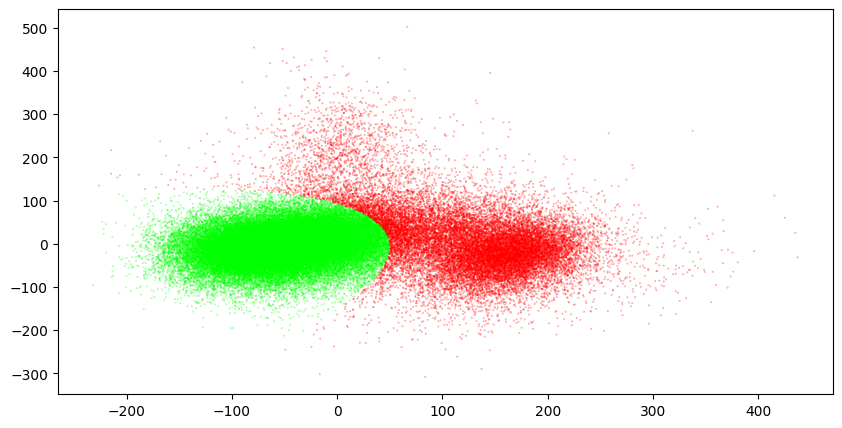

In [46]:
means, covariances, mixing_probs, nums = mixture_of_gaussians(projected_2d_data, 2)

index_max = np.argmax(nums, axis=1)
colors = np.array([[1, 0, 0], [0, 1, 0]])

plt.figure(figsize=(10, 5))
plt.scatter(projected_2d_data[:, 0], projected_2d_data[:, 1], c=colors[index_max], alpha=0.5, s=0.1)
plt.show()

# results are more interesting given that it seems we have these 2 clusters
# red and green that seem to be clusters along the PC1 axis.
# we also observe a interesting boundary between the two clusters, probably
# since the red cluster has a significantly larger variance

---

## 2) Factor Analysis

a) Write coode to simulate data from the 2D factor analysis model we considered in class, with parameters:

$A = \begin{bmatrix} 1 \\ 2 \end{bmatrix}$
$\Psi = \begin{bmatrix} 100 & 0 \\ 0 & 1 \end{bmatrix}$

Generate 500 samples of 1-dimensional latent $z$ and use them to generate 2-dimensional samples $x$. Make a scatter plot showing the $x$ samples, and overlay a unit vector pointing in the direction of $A$. Finally, add a unit vector pointing in the direction of the top principal component.


In [47]:
A = np.array([[1], [2]])
Psi = np.array([[100, 0], [0, 1]])

samples_z = np.random.normal(size=(500,1))
samples_x = samples_z.dot(A.T) + np.random.multivariate_normal(np.zeros(2), Psi, 500)

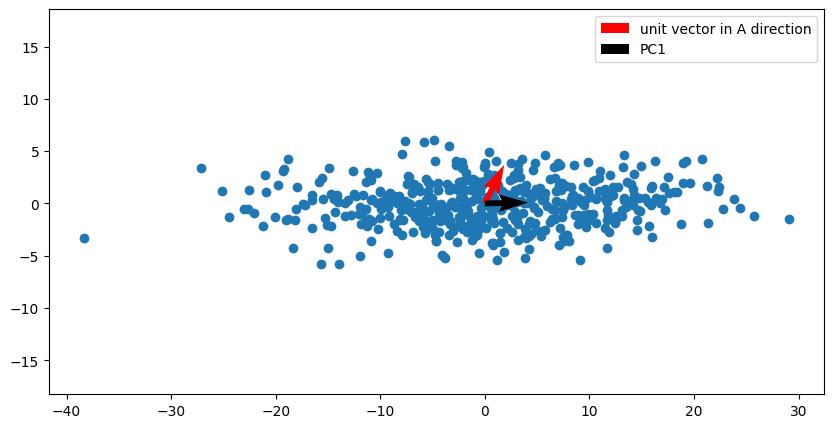

In [48]:
plt.figure(figsize=(10, 5))
plt.scatter(samples_x[:, 0], samples_x[:, 1])
A_normed = A / np.linalg.norm(A)
plt.quiver(0, 0, A_normed[0], A_normed[1], color='r', label='unit vector in A direction')

x_centered = samples_x - np.mean(samples_x, axis=0)
U, S, Vt = np.linalg.svd(x_centered, full_matrices=False)
top_pc = Vt[0] / np.linalg.norm(Vt[0])
plt.quiver(0, 0, top_pc[0], top_pc[1], color='black', label='PC1')

plt.legend()
plt.axis('equal')
plt.show()

b) Write code to perform EM inference for the Factor Analysis model. Run this code on the data from the above simulation, and show that you can recover an estimate of $A$ and the diagonal entries of $\Psi$.


In [49]:
def FA_EM(data, num_factors, n_iters=1000):
    num_samples, num_features = data.shape
    
    A = np.random.randn(num_features, num_factors)
    Psi = np.diag(np.var(data, axis=0))
    
    for _ in range(n_iters):
        # E step
        inv_psi = np.linalg.inv(Psi)
        M = np.linalg.inv(np.eye(num_factors) + A.T @ inv_psi @ A)
        mu_z = M @ A.T @ inv_psi @ data.T

        # M step
        A_new = (data.T @ mu_z.T @ np.linalg.inv(M * num_samples + mu_z @ mu_z.T))
        Psi_new_no_diag = np.mean(data**2, axis=0) - np.mean(A_new @ mu_z @ data, axis=0)
        
        A = A_new
        Psi = np.diag(Psi_new_no_diag)
                
    return A, Psi

In [50]:
A_estimate, Psi_estimate = FA_EM(samples_x, num_factors=1)
print("Estimated A:\n", A_estimate)
print("Estimated Psi:\n", Psi_estimate)

Estimated A:
 [[0.3053146 ]
 [0.00949904]]
Estimated Psi:
 [[76.39055526  0.        ]
 [ 0.          3.82033448]]


c) Fit the probabilistic PCA model to the same dataset. (See the slides from the PPCA lecture for details). What is the estimated value of the noise variance $\sigma^2$? Make a plot showing the true A, the A estimate from fitting the FA model, and the A estimate from the PPCA model. (Plot all 3 as vectors in a 2D plane).


In [51]:
x_centered = samples_x - np.mean(samples_x, axis=0)
ppca_estimate_projected, principal_components, noise_var = ppca(x_centered, 1)
print(f"the noise variance is: {noise_var}")

the noise variance is: 4.540129676717291


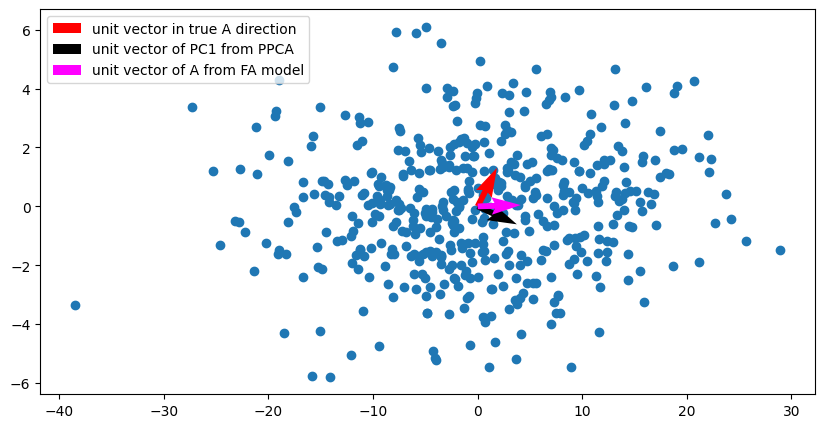

In [52]:
plt.figure(figsize=(10, 5))
plt.scatter(x_centered[:, 0], x_centered[:, 1])
plt.quiver(0, 0, A_normed[0], A_normed[1], color='r', label='unit vector in true A direction')
plt.quiver(0, 0, ppca_estimate_projected[0], ppca_estimate_projected[1], color='black', label='unit vector of PC1 from PPCA')
plt.quiver(0, 0, A_estimate[0], A_estimate[1], color='magenta', label='unit vector of A from FA model')
plt.legend()